# ResNet-18
Credit to: [Using ResNet for MNIST in PyTorch 1.7](https://zablo.net/blog/post/pytorch-resnet-mnist-jupyter-notebook-2021/)

##Python Setup

In [1]:
!git clone https://github.com/HanziJiang/Hahaha-Project.git

Cloning into 'Hahaha-Project'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 67 (delta 33), reused 23 (delta 10), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [2]:
!pip install torch torchvision
!pip install matplotlib
!pip install import-ipynb
!pip install pytorch_extras
!pip install pytorch_lightning

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=2097f84bd08bf914b6f87eba50165fe67dc0bbfe1c337931f43e478ce14225d3
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
  Created wheel for pytorch-extras: filename=pytorch_extras-0.1.3-cp37-none-any.whl size=2833 sha256=afa742b8cb2df2f4cae6933b5c89a2b1f812867906d7a98c25e16208df073c3f
  Stored in directory: /root/.cache/pip/wheels/5b/7c/5a/f27d4088adfe722cb280d523a1ed9eeb33be11b8d3a653292a
Successfully built pytorch-extras
     |████████████████████████████████| 849kB 14.0MB/s 
     |████████████████████████████████| 276kB 23.5MB/s 
     |████████████████████████████████| 112kB 51.1MB/s 
     |████████████████████████████████| 184kB 53.6MB/s 
     |████████████████████████████████| 829kB 53.3MB/s 
     |████████████████████████████████| 1.3MB 50.4MB/s 
     |████████████████████████████████| 296kB 52.9MB/s 


In [3]:
# from google.colab import drive
# drive.mount("mnt")
# %cd "mnt/My Drive"

In [4]:
%cd "Hahaha-Project"

/content/Hahaha-Project


importing Jupyter notebook from load_DrawData_with_transform.ipynb
     |████████████████████████████████| 71kB 7.9MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=00dabe6f095b03eead2b03f79a2d868cb666accba109067c2d46c0656ba12f36
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
6000
4000
total training samples: 6000
total validatoin samples: 2000
total test samples: 2000
gs://quickdraw_dataset/full/simplified/apple.ndjson
Copying gs://quickdraw_dataset/full/simplified/apple.ndjson...
\ [1/1 files][ 56.1 MiB/ 56.1 MiB] 100% Done                                    
Operation completed over 1 objects/56.1 MiB.                                     
gs://quickdraw_dataset/full/simplified/face.ndjson
Copying gs://quickdraw_dataset/full/simplified/face.ndjson...
| [1/1 files][ 89.4 MiB/ 89.4 MiB] 100% Done                                    
Operation completed

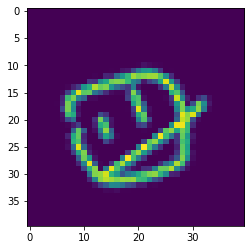

[0. 1.]
face


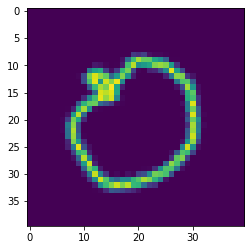

[1. 0.]
apple
2000
2000


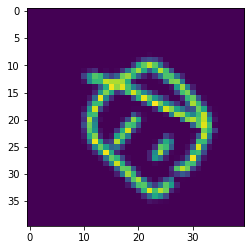

[0. 1.]
face


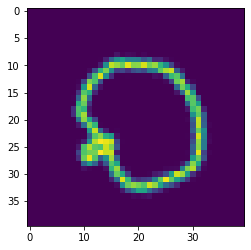

[1. 0.]
apple


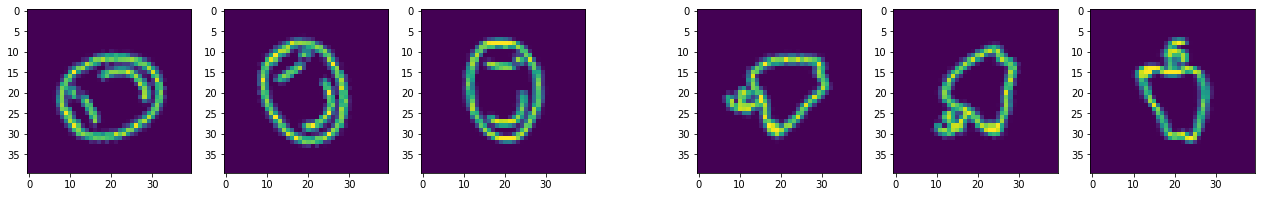

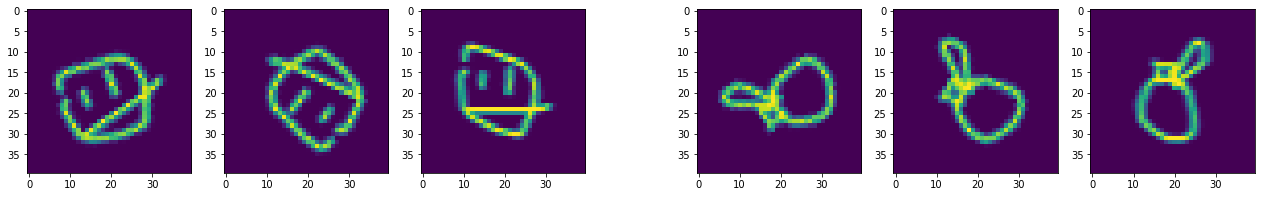

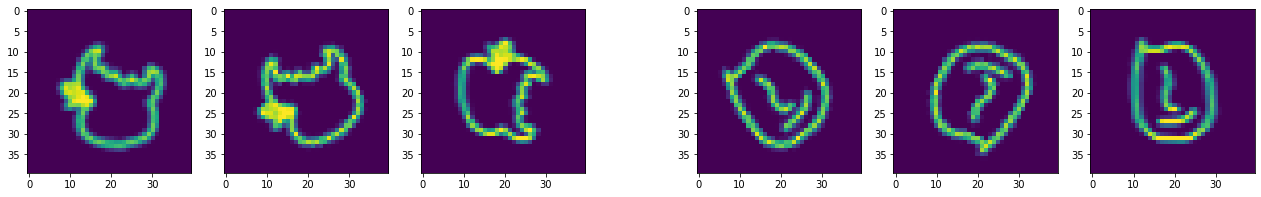

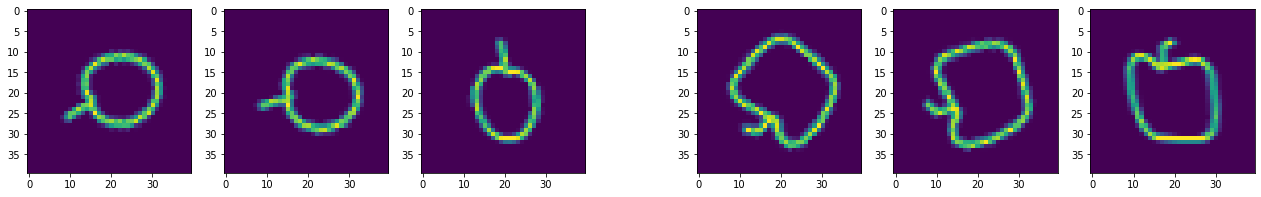

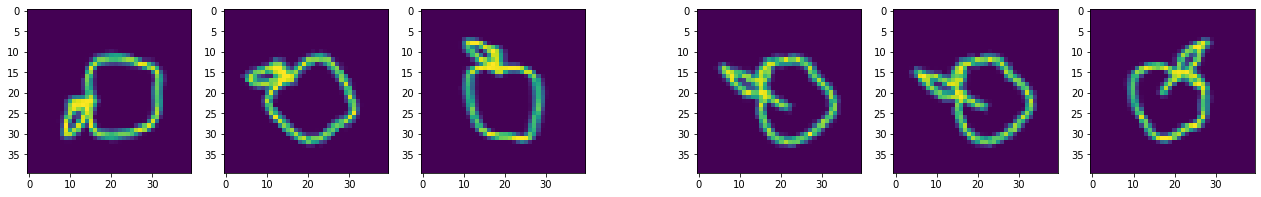

In [5]:
from torchvision.models import resnet18
from torch import nn
import torch
import numpy as np
import import_ipynb
import load_DrawData_with_transform as loader
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data

## Model

In [6]:
class ResNet(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = resnet18()
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.loss = nn.CrossEntropyLoss()

  @auto_move_data
  def forward(self, x):
    x = torch.unsqueeze(x, 1)
    return self.model(x.float())
  
  def training_step(self, batch, batch_no):
    # implement single training step
    x, y = batch
    logits = self(x)
    y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(), lr=0.005)

## Train

In [24]:
train_loader, valid_loader, test_loader = loader.train_loader, loader.val_loader, loader.test_loader

model = ResNet()
model = model.cuda()

trainer = pl.Trainer(
    max_epochs=2,
    progress_bar_refresh_rate=30 # set to >= 20 if running in Google Colab
)

#model
trainer.fit(model, train_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.7 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.733    Total estimated model params size (MB)


1

In [25]:
trainer.save_checkpoint("resnet18_quickdraw.pt")

In [26]:
def get_prediction(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

In [27]:
from tqdm.autonotebook import tqdm

In [28]:
inference_model = ResNet.load_from_checkpoint("resnet18_quickdraw.pt", map_location="cuda")

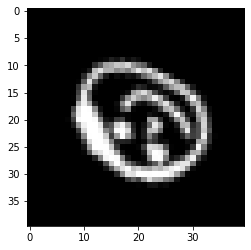

In [29]:
import matplotlib.pyplot as plt
for i, (data,target) in enumerate(test_loader):
    plt.imshow(data[0], cmap = "gray")
    if i == 1: break

In [30]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
  x, y = batch
  y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

In [31]:
# Test accuracy
np.mean(np.equal(true_y, pred_y))

0.7755

In [32]:
true_y, pred_y = [], []
for batch in tqdm(iter(valid_loader), total=len(valid_loader)):
  x, y = batch
  y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

In [33]:
# Validation accuracy
np.mean(np.equal(true_y, pred_y))

0.988

In [34]:
from sklearn.metrics import classification_report